In [1]:
import numpy as np, math
import matplotlib.pyplot as plt

In [2]:
c = 299792458.0
GMe = 3.986004418e14
R_earth = 6378137.0
omega_earth = 7.2921150e-5

def kepler_orbit(a, e, inc, Omega, omega, M0, t_array, mu=GMe):
    n = math.sqrt(mu / a**3)
    M = M0 + n * t_array
    E = np.copy(M)
    for _ in range(20):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        E -= f/fp
    nu = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))
    r_mag = a*(1 - e*np.cos(E))
    x_orb = r_mag * np.cos(nu)
    y_orb = r_mag * np.sin(nu)
    rdot = (np.sqrt(mu*a)/r_mag) * e*np.sin(E)
    nudot = (np.sqrt(mu*a)/r_mag**2) * np.sqrt(1-e**2)
    vx_orb = rdot*np.cos(nu) - y_orb*nudot
    vy_orb = rdot*np.sin(nu) + x_orb*nudot
    cO, sO = np.cos(Omega), np.sin(Omega)
    co, so = np.cos(omega), np.sin(omega)
    ci, si = np.cos(inc), np.sin(inc)
    RzO = np.array([[cO,-sO,0],[sO,cO,0],[0,0,1]])
    RxI = np.array([[1,0,0],[0,ci,-si],[0,si,ci]])
    Rzo = np.array([[co,-so,0],[so,co,0],[0,0,1]])
    Q = RzO @ RxI @ Rzo
    r_eci = Q @ np.vstack((x_orb, y_orb, np.zeros_like(x_orb)))
    v_eci = Q @ np.vstack((vx_orb, vy_orb, np.zeros_like(vx_orb)))
    return r_eci.T, v_eci.T, r_mag, np.sqrt((v_eci**2).sum(axis=0))

def satellite_clock_offset(a, e=0.0, inc=np.deg2rad(56.0), duration_hours=12, samples=4000):
    T = 2*math.pi*math.sqrt(a**3/GMe)
    t = np.linspace(0, duration_hours*3600, samples)
    r_vec, v_vec, r_mag, v_mag = kepler_orbit(a, e, inc, 0.0, 0.0, 0.0, t)
    U_sat = -GMe / r_mag
    U_ground = -GMe / R_earth
    v_ground = omega_earth * R_earth
    frac_rate = (U_sat - U_ground)/c**2 - (v_mag**2 - v_ground**2)/(2*c**2)
    dt = t[1]-t[0]
    offset = np.cumsum(frac_rate)*dt
    return t, offset

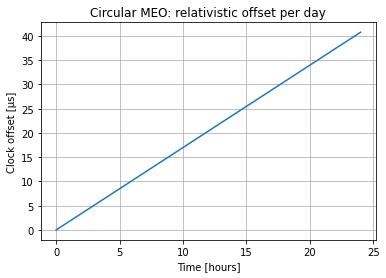

In [3]:
a_galileo = 29600000.0
t1, off1 = satellite_clock_offset(a_galileo, e=0.0, duration_hours=24, samples=5000)
plt.figure()
plt.plot(t1/3600.0, off1*1e6)
plt.xlabel("Time [hours]"); plt.ylabel("Clock offset [µs]")
plt.title("Circular MEO: relativistic offset per day"); plt.grid(True)
#plt.savefig("proj1_circular_offset.png", dpi=160, bbox_inches="tight")
plt.show()

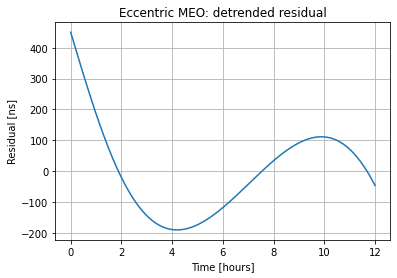

In [4]:
t2, off2 = satellite_clock_offset(a_galileo, e=0.16, duration_hours=12, samples=4000)
p = np.polyfit(t2, off2, 1)
plt.figure()
plt.plot(t2/3600.0, (off2 - np.polyval(p, t2))*1e9)
plt.xlabel("Time [hours]"); plt.ylabel("Residual [ns]")
plt.title("Eccentric MEO: detrended residual"); plt.grid(True)
#plt.savefig("Eccentric MEO: detrended residual", dpi=160, bbox_inches="tight")
plt.show()